<a href="https://colab.research.google.com/github/igquinteroch/deep-learning-coursework/blob/main/01_fundamentals_DL_CNN_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks with PyTorch

**Resources**:

From: https://www.youtube.com/@PepeCantoralPhD

1. Red Neuronal Convolucional en PyTorch / Tutorial de PyTorch para CNN - Parte 1:

  https://www.youtube.com/watch?v=yUB9JQQVtoU&list=PLWzLQn_hxe6ZlC9-YMt3nN0Eo-ZpOJuXd&index=37


2. Red Neuronal Convolucional en PyTorch con Batch Normalization/Tutorial de PyTorch para CNNs -Parte 2:

  https://www.youtube.com/watch?v=NLrQZwnWjvI&list=PLWzLQn_hxe6ZlC9-YMt3nN0Eo-ZpOJuXd&index=38


### Import the libraries and set the stage

* `os`: Allows interaction with the OS - e.g., directory navigation.
* `numpy`: Performs mathematical operations on large arrays or matrices.
* `matplotlib.pyplot`: Used for plotting data.

**PyTorch**

* `torch`: Fundamental PyTorch library.
* `torch.nn`: The module `torch.nn` contains classes and functions for building neural networks.
* `torch.nn.functional`: Imports the `torch.nn` module, which contains functions that operate on tensors.
* `from torch.utils.data import DataLoader`: Imports the `DataLoader` class, which is used to load data efficiently in batches during training and evaluation.
* `from torch.utils.data import sampler`: Imports tools for creating data samplers.
* `torchvision.datasets`: Imports the `datasets` module from torchvision, which is an easy access to common datasets such as CIFAR-10.
* `torchvision.transforms`: Imports the `transforms` from torchvision. Provides various transformations to apply for the data such as resizing, croppign, flipping and normalization.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T


# Provides access to the Drive from within the notebook
from google.colab import drive

# Mounts the Drive into the Colab environment
drive.mount("/content/drive")

# Changes the current working directory to the specified path in Google Drive.
os.chdir("/content/drive/MyDrive/TC5033.10")

DATA_PATH = '/content/drive/MyDrive/TC5033.10/cifar-10-batches-py'

Mounted at /content/drive


In [ ]:
# Number of images to use for training, validation and testing
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64 # images processed at a time during training

# Data Transformation

transform_cifar = T.Compose([
                T.ToTensor(),
                # Known values for the cifar10 dataset
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261]) # [mean values, std values]
            ])

# Dataset and DataLoader Creation

# train=True : load the training portion of the CIFAR-10 dataset
# download=True : ensures the dataset is downloaded if not already present
# transform=transform_cifar : applies a set of transformations in the dataset

cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)

# sampler.SubsetRandomSampler(): creates a sampler object that will randomly select samples from a given set of indices

train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))


cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Check the content of the dataset
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/TC5033.10/cifar-10-batches-py
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [ ]:
# Check the content of the dataset
test_loader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/TC5033.10/cifar-10-batches-py
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

### Use GPUs

To check if a GPU is available, if not, use a CPU.

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Show Images

Randomly select and display an image and its label from the dataset.

In [ ]:
# Get the list of class names from the datasets
classes = test_loader.dataset.classes

def plot_figure(image):
    # Rearrange the dimensions of the image array to match the expected format
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

The image shown represents a/an: ship


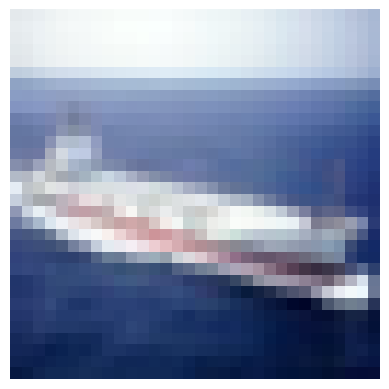

In [ ]:
# Generate a random index within the range of the available batches
rnd_sample_idx = np.random.randint(len(test_loader))
print(f'The image shown represents a/an: {classes[test_loader.dataset[rnd_sample_idx][1]]}')

# Retrieve the actual image
image = test_loader.dataset[rnd_sample_idx][0]

# Normalize the pixel values of the image to a range between 0 and 1
# It is helpful for displaying correct images and improve performance
image = (image - image.min()) / (image.max() -image.min() )

# Plot the image
plot_figure(image)

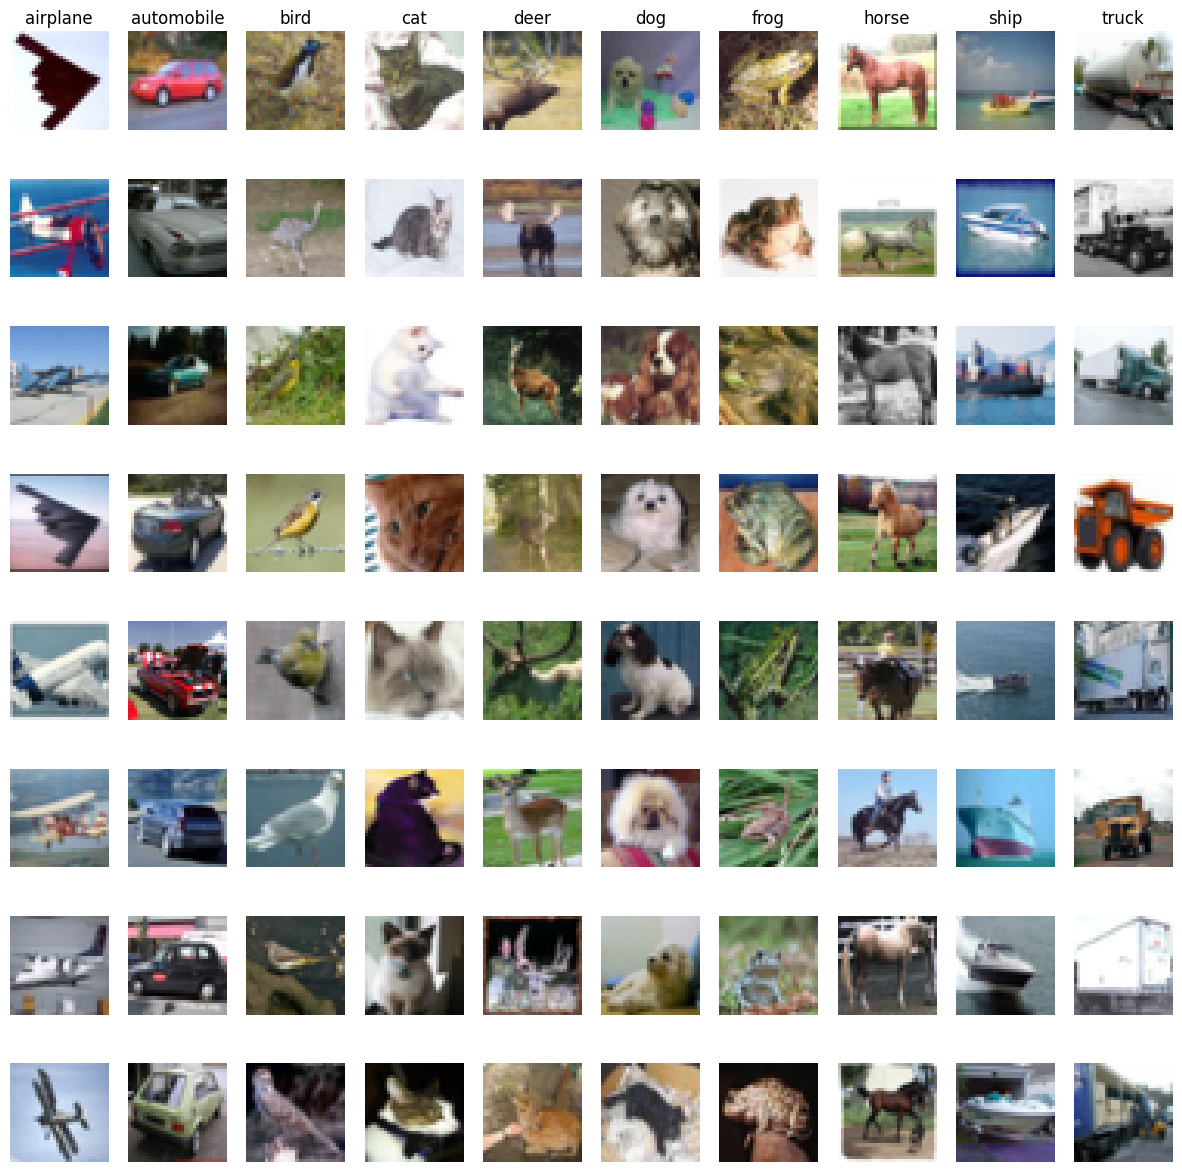

In [ ]:
# Get 8 random images and show them in columns
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))

    # Iterate through each class in the dataset
    for label, sample in enumerate(classes):
        # Find the indices of all images that belong to the current label
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        # Select a random subset of images
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        # Create and display a grid of images
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')

            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid()

### Calculate accuracy

Accuracy is a metric that measures the proportion of correctly classified instances out of the total number of instances.

In [ ]:
# Inspect the data and print batch size, dimensions of inputs and labels
for i, (x,y) in enumerate(test_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 32, 32]) torch.Size([64])
1 torch.Size([64, 3, 32, 32]) torch.Size([64])
2 torch.Size([64, 3, 32, 32]) torch.Size([64])
3 torch.Size([64, 3, 32, 32]) torch.Size([64])
4 torch.Size([64, 3, 32, 32]) torch.Size([64])
5 torch.Size([64, 3, 32, 32]) torch.Size([64])
6 torch.Size([64, 3, 32, 32]) torch.Size([64])
7 torch.Size([64, 3, 32, 32]) torch.Size([64])
8 torch.Size([64, 3, 32, 32]) torch.Size([64])
9 torch.Size([64, 3, 32, 32]) torch.Size([64])
10 torch.Size([64, 3, 32, 32]) torch.Size([64])
11 torch.Size([64, 3, 32, 32]) torch.Size([64])
12 torch.Size([64, 3, 32, 32]) torch.Size([64])
13 torch.Size([64, 3, 32, 32]) torch.Size([64])
14 torch.Size([64, 3, 32, 32]) torch.Size([64])
15 torch.Size([64, 3, 32, 32]) torch.Size([64])
16 torch.Size([64, 3, 32, 32]) torch.Size([64])
17 torch.Size([64, 3, 32, 32]) torch.Size([64])
18 torch.Size([64, 3, 32, 32]) torch.Size([64])
19 torch.Size([64, 3, 32, 32]) torch.Size([64])
20 torch.Size([64, 3, 32, 32]) torch.Size([64])
21

In [ ]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    # Set the model to evaluation mode
    model.eval()
    # Move the model to the specified device
    model = model.to(device=device)
    # Disable gradient calculation during the evaluation process
    with torch.no_grad():
      # xi : input data (images)
      # yi : labels or targets
        for xi, yi in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            # The model makes predictions
            scores = model(xi)
            # Extract the predicted labels from the scores
            _, pred = scores.max(dim=1)
            num_correct += (pred == yi).sum()
            num_total += pred.size(0)
        return float(num_correct)/num_total

### Training loop

Define the training process for the model.

The `train` function processes batches of the data, calculate the loss, update model's parameters to minimize the loss, and tracks the performance on a validation test.

In [ ]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # Calculate the loss or cost function using cross-entropy
            cost = F.cross_entropy(input= scores, target=yi)
            # Reset the gradients to zero before calculate new gradients
            optimiser.zero_grad()
            # Calculate the gradients of the loss function using backpropagation
            cost.backward()
            # Update parameters
            optimiser.step()
        # Calculate the accuracy on the validation dataset
        acc = accuracy(model, val_loader)
        print(f'Epoch: {epoch} | Cost Function: {cost.item()} | Accuracy: {acc}')

### Sequential linear

Define a sequential neural network with hidden layers, set hyperparameters for training, and initializes an optimizer to update the weights during training.

In [ ]:
hidden1 = 256 # 256 neurons
hidden = 256
lr = 0.001 # lr : controls how much the parameters are adjusted during each training step
epochs = 10 # number of times the dataset will be passed through the model during the training process

# Define the structure of the neural network
model1 = nn.Sequential(nn.Flatten(), # transform the input image into a 1D array
                       nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
# Update the model's parameters to minimize the loss function
# Adam algorithm - update the weights of a NN during training
optimiser = torch.optim.Adam(model1.parameters(), lr=lr)

In [ ]:
train(model1, optimiser, epochs)

Epoch: 0 | Cost Function: 2.090789794921875 | Accuracy: 0.472
Epoch: 1 | Cost Function: 1.1608710289001465 | Accuracy: 0.498
Epoch: 2 | Cost Function: 1.7248708009719849 | Accuracy: 0.5094
Epoch: 3 | Cost Function: 1.4069973230361938 | Accuracy: 0.5108
Epoch: 4 | Cost Function: 1.2645589113235474 | Accuracy: 0.5226
Epoch: 5 | Cost Function: 0.8824543356895447 | Accuracy: 0.5248
Epoch: 6 | Cost Function: 1.3650176525115967 | Accuracy: 0.5264
Epoch: 7 | Cost Function: 0.9324775338172913 | Accuracy: 0.5262
Epoch: 8 | Cost Function: 0.7542084455490112 | Accuracy: 0.5278
Epoch: 9 | Cost Function: 0.6742237210273743 | Accuracy: 0.5274


### Sequential CNN

Define a CNN architecture, set hyperparameters for its training, and initialize an optimizer for fine-tune model's weights for better performance on the dataset.

* `nn.Conv2d`: Creates a 2-dimensional convolutional layer (used to extract features from images.)

* `in_channels`: The number of input channels the convolutional layer
will receive (number of color channels - 3 for RGB).

* `out_channels`: Set the number of output channels for the convoluitonal layer (filters applied to the input). Each filter learns to detect different features in the input.

* `kernel_size`: The size of the convolutional kernel or filter. 3 means 3x3 square matrix.

* `padding`: Extra pixels around the borders of the input image before applying the convolution.

In [ ]:
channel1 = 16 # number of output channels for the first convolutional layer
channel2 = 32 # number of output channels for the second convolutional layer
epochs = 10
lr = 0.0001

# Define the CNN model
# nn.Conv2d : 2d convolutional layer
modelCNN1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=channel1,
                                   kernel_size=3, padding=1),
                          nn.ReLU(),
                          nn.Conv2d(in_channels=channel1, out_channels=channel2,
                                    kernel_size= 3, padding=1),
                          nn.ReLU(),
                          # Reduces the spatial dimensions of the data
                          nn.MaxPool2d(2, 2),
                          # To a single vector
                          nn.Flatten(),
                          # Fully connected linear layer
                          nn.Linear(in_features=16*16*channel2, out_features=10)
                                   )
# Setting up the optimizer
optimiser = torch.optim.Adam(modelCNN1.parameters(), lr)

In [ ]:
train(modelCNN1, optimiser, epochs)

Epoch: 0 | Cost Function: 1.433546781539917 | Accuracy: 0.4738
Epoch: 1 | Cost Function: 1.6362909078598022 | Accuracy: 0.511
Epoch: 2 | Cost Function: 1.3731060028076172 | Accuracy: 0.539
Epoch: 3 | Cost Function: 1.633499026298523 | Accuracy: 0.5574
Epoch: 4 | Cost Function: 1.0728492736816406 | Accuracy: 0.5748
Epoch: 5 | Cost Function: 1.170729398727417 | Accuracy: 0.5848
Epoch: 6 | Cost Function: 1.2830071449279785 | Accuracy: 0.587
Epoch: 7 | Cost Function: 1.2086694240570068 | Accuracy: 0.6026
Epoch: 8 | Cost Function: 0.9611807465553284 | Accuracy: 0.6102
Epoch: 9 | Cost Function: 0.6939840316772461 | Accuracy: 0.614


### Using Object Oriented Programming

Define a Convolutional Neural Network using PyTorch's object-oriented approach.

* `nn.Conv2d`: Creates a 2-dimensional convolutional layer (used to extract features from images.)

* `in_channels`: The number of input channels the convolutional layer
will receive (number of color channels - 3 for RGB).

* `out_channels`: Set the number of output channels for the convoluitonal layer (filters applied to the input). Each filter learns to detect different features in the input.

* `kernel_size`: The size of the convolutional kernel or filter. 3 means 3x3 square matrix.

* `padding`: Extra pixels around the borders of the input image before applying the convolution.

In [ ]:
class CNN_class1(nn.Module): # Inherits from nn.Module - the CNN_class1 gains the functionality needed to be treated as a PyTorch NN.
    def __init__(self, in_channel, channel1, channel2):
        # Initializes the parent class
        super().__init__()
        # First Convolutional Layer - used to extract features from images
        self.conv1 = nn.Conv2d(in_channels = in_channel, out_channels = channel1,
                              kernel_size=3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = channel1, out_channels = channel2,
                              kernel_size=3, padding=1)
        # Reduces the spatial dimensions of the data
        self.max_pool = nn.MaxPool2d(2,2)
        # Fully connected linear layer
        self.fc = nn.Linear(in_features=16*16*channel2, out_features=10)
        # To a single vector
        self.flatten = nn.Flatten()
    # Describe the sequence of operations performed on the input image as it passes through the CNN
    def forward(self, x):
        x = F.relu(self.conv2(F.relu(self.conv1(x))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)

In [ ]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001
modelCNN2 = CNN_class1(3, channel1, channel2)
optimiser = torch.optim.Adam(modelCNN2.parameters(), lr)

In [ ]:
train(modelCNN2, optimiser, epochs)

Epoch: 0 | Cost Function: 1.1192598342895508 | Accuracy: 0.4886
Epoch: 1 | Cost Function: 1.1154807806015015 | Accuracy: 0.5352
Epoch: 2 | Cost Function: 1.3833153247833252 | Accuracy: 0.5632
Epoch: 3 | Cost Function: 0.9678153395652771 | Accuracy: 0.587
Epoch: 4 | Cost Function: 0.7716672420501709 | Accuracy: 0.5974
Epoch: 5 | Cost Function: 1.1109211444854736 | Accuracy: 0.6124
Epoch: 6 | Cost Function: 0.6883124709129333 | Accuracy: 0.6184
Epoch: 7 | Cost Function: 0.9053788185119629 | Accuracy: 0.635
Epoch: 8 | Cost Function: 0.909541130065918 | Accuracy: 0.6286
Epoch: 9 | Cost Function: 0.5824077725410461 | Accuracy: 0.6464


### Just a little more elegant

In [ ]:
# Creating a lambda function - Define the function's inputs, two arguments: `channel1` and `channel2`
conv_k_3 = lambda channel1, channel2: nn.Conv2d(channel1, channel2, kernel_size=3, padding=1)

In [ ]:
class CNN_class2(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        # First Convolutional layer
        self.conv1 = conv_k_3(in_channel, channel1)
        # Initialize the weights using the Kaiming initialization (training stability)
        nn.init.kaiming_uniform_(self.conv1.weight)

        # Second Convolutional layer
        self.conv2 = conv_k_3(channel1, channel2)
        self.max_pool = nn.MaxPool2d(2,2)

        # Create a fully connected linear
        self.fc = nn.Linear(in_features=16*16*channel2, out_features=10)
        self.flatten = nn.Flatten()
    # Describe the sequence of operations performed on the input image as it passes through the CNN
    def forward(self, x):
        x = F.relu(self.conv2(F.relu(self.conv1(x))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)

In [ ]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001
modelCNN3 = CNN_class2(3, channel1, channel2)
optimiser = torch.optim.Adam(modelCNN3.parameters(), lr)

In [ ]:
train(modelCNN3, optimiser, epochs)

Epoch: 0 | Cost Function: 1.2372252941131592 | Accuracy: 0.4942
Epoch: 1 | Cost Function: 1.4026682376861572 | Accuracy: 0.537
Epoch: 2 | Cost Function: 1.2228366136550903 | Accuracy: 0.572
Epoch: 3 | Cost Function: 1.1047282218933105 | Accuracy: 0.586
Epoch: 4 | Cost Function: 0.9520003795623779 | Accuracy: 0.6032
Epoch: 5 | Cost Function: 0.8569657206535339 | Accuracy: 0.6118
Epoch: 6 | Cost Function: 1.1647675037384033 | Accuracy: 0.6188
Epoch: 7 | Cost Function: 0.8397601842880249 | Accuracy: 0.6316
Epoch: 8 | Cost Function: 1.1379477977752686 | Accuracy: 0.6278
Epoch: 9 | Cost Function: 1.0417215824127197 | Accuracy: 0.6378


In [ ]:
class CNN_class3(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, channel1)
        # Add a batch normalization to help stabilize training and improve performance
        self.bn1 = nn.BatchNorm2d(channel1)

        self.conv2 = conv_k_3(channel1, channel2)
        # Add a batch normalization after the second convolutional layer
        self.bn2 = nn.BatchNorm2d(channel2)

        self.max_pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(in_features=16*16*channel2, out_features=10)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)

In [ ]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001
modelCNN4 = CNN_class3(3, channel1, channel2)
optimiser = torch.optim.Adam(modelCNN4.parameters(), lr)

In [ ]:
train(modelCNN4, optimiser, epochs)

Epoch: 0 | Cost Function: 0.806256115436554 | Accuracy: 0.5802
Epoch: 1 | Cost Function: 0.8646808862686157 | Accuracy: 0.6214
Epoch: 2 | Cost Function: 0.7363938689231873 | Accuracy: 0.6408
Epoch: 3 | Cost Function: 0.7704375982284546 | Accuracy: 0.6616
Epoch: 4 | Cost Function: 1.270390510559082 | Accuracy: 0.6614
Epoch: 5 | Cost Function: 0.5583251714706421 | Accuracy: 0.664
Epoch: 6 | Cost Function: 0.8507885932922363 | Accuracy: 0.6678
Epoch: 7 | Cost Function: 0.7396567463874817 | Accuracy: 0.6802
Epoch: 8 | Cost Function: 0.9721208214759827 | Accuracy: 0.6638
Epoch: 9 | Cost Function: 0.5853263735771179 | Accuracy: 0.681


In [ ]:
class CNN_class4(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, channel1)
        self.bn1 = nn.BatchNorm2d(channel1)

        self.conv2 = conv_k_3(channel1, channel2)
        self.bn2 = nn.BatchNorm2d(channel2)

        self.max_pool = nn.MaxPool2d(2,2)

    def forward(self, x):
        x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))
        return self.max_pool(x)

In [ ]:
channel1 = 16
channel2 = 32
channel3 = 64
channel4 = 128
epochs = 10
lr = 0.001
modelCNN5 = nn.Sequential(CNN_class4(3,channel1, channel2),
                          CNN_class4(channel2, channel4, channel4),
                          nn.Flatten(),
                          nn.Linear(in_features=8*8*channel4, out_features=10))

optimiser = torch.optim.Adam(modelCNN5.parameters(), lr)

In [ ]:
train(modelCNN5, optimiser, epochs)

Epoch: 0 | Cost Function: 1.0419312715530396 | Accuracy: 0.627
Epoch: 1 | Cost Function: 0.5958582162857056 | Accuracy: 0.715
Epoch: 2 | Cost Function: 0.6218721270561218 | Accuracy: 0.7506
Epoch: 3 | Cost Function: 0.4696210026741028 | Accuracy: 0.7602
Epoch: 4 | Cost Function: 0.3619774878025055 | Accuracy: 0.7496
Epoch: 5 | Cost Function: 0.5604099035263062 | Accuracy: 0.792
Epoch: 6 | Cost Function: 0.3604210615158081 | Accuracy: 0.794
Epoch: 7 | Cost Function: 0.23307061195373535 | Accuracy: 0.7772
Epoch: 8 | Cost Function: 0.23436304926872253 | Accuracy: 0.783
Epoch: 9 | Cost Function: 0.10537884384393692 | Accuracy: 0.778


In [ ]:
accuracy(modelCNN5, test_loader)

0.7822